in this project we will try to make a shopping list where we can take all user products he saved , find relations between these items , so the next time we will recommend similar products he used to buy with the items he has already entered

# 1- EDA

In [1]:
import sys
import random
import pickle
import numpy as np
import pandas as pd
import pyarrow as pa
import seaborn as sns
from os import listdir
from os import cpu_count
from typing import List
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from zipfile import ZipFile
import pyarrow.parquet as pq
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from toolz.functoolz import pipe
from gensim.models import Word2Vec
from itertools import chain
from numpy.lib.stride_tricks import sliding_window_view
from typing import List
from os import listdir


color = sns.color_palette()
sns.set_theme()
%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
order_products_train_df = pd.read_csv("order_products__train.csv")
order_products_prior_df = pd.read_csv("order_products__prior.csv")
orders_df = pd.read_csv("orders.csv")
products_df = pd.read_csv("products.csv")
aisles_df = pd.read_csv("aisles.csv")
departments_df = pd.read_csv("departments.csv")

In [3]:
order_products_train_df   

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [4]:
order_products_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [5]:
order_products_prior_df  

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [6]:
order_products_prior_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


Both the files `orders_prduct_prior` and ```orders_prduct_train``` seem to have the same columns. Whereas the `orders_prduct_prior` contains over 32.4m rows, the `orders_prduct_train` only contain 1.38m rows. For our project, building a recomennder system, this is irrelevant and, as such, we will merge the two file and explore the merged together.

In [7]:
order_products_df = pd.concat([order_products_prior_df, order_products_train_df])
order_products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33819106 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 1.3 GB


In [8]:
order_products_df.sort_values("order_id")

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
...,...,...,...,...
32434483,3421083,35211,5,0
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0


### 1.2.1 Orders

In [9]:
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [10]:
orders_df = orders_df.drop('eval_set' , axis=1 )
orders_df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0
2,473747,1,3,3,12,21.0
3,2254736,1,4,4,7,29.0
4,431534,1,5,4,15,28.0


In [11]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 6 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
dtypes: float64(1), int64(5)
memory usage: 156.6 MB


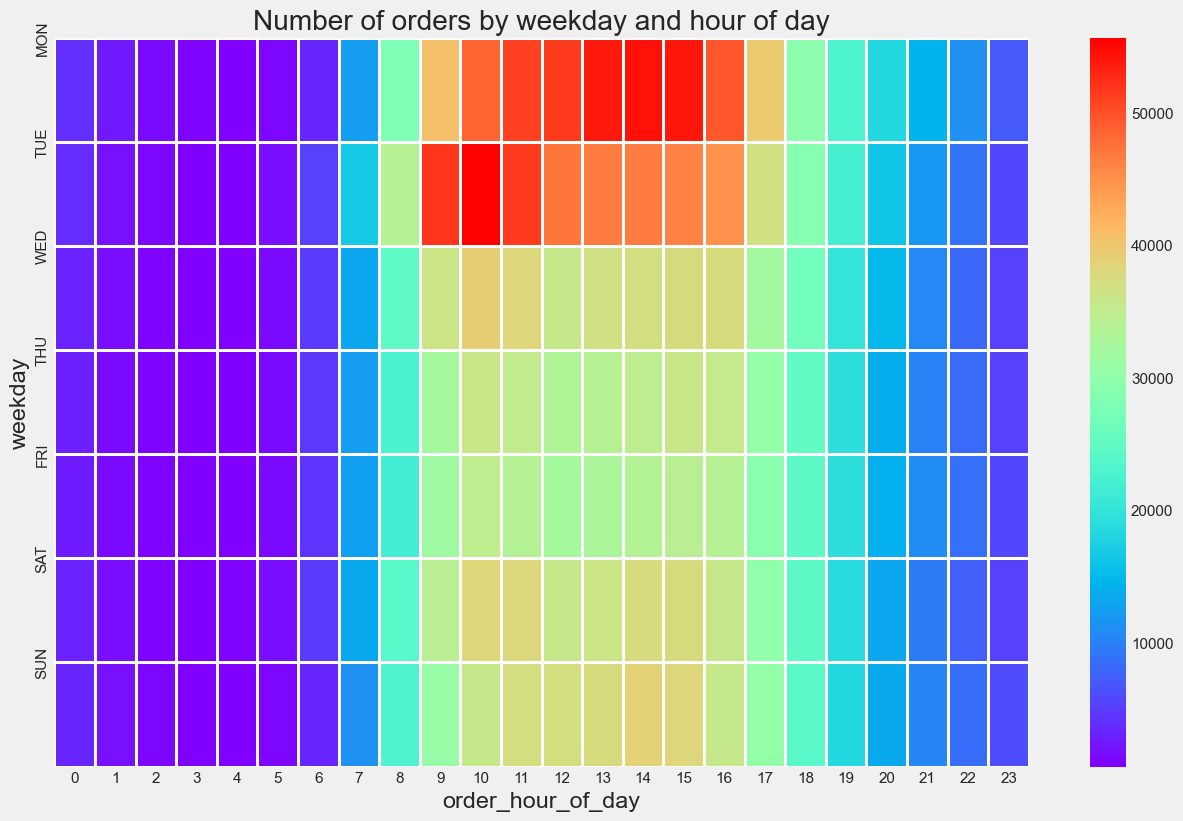

In [12]:
plt.figure(figsize=(14, 9))
sns.heatmap(orders_df.groupby(['order_dow', 'order_hour_of_day']).size().unstack(fill_value=0), cmap="rainbow", linewidth=1)
plt.title("Number of orders by weekday and hour of day")
plt.yticks(ticks=range(0, 7), labels=["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"])
plt.ylabel("weekday")
plt.show()

In [13]:
products_df

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [14]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


There are a total of 49688 unique products. Let's explore how these products are distributed with regard to the departments and aisles. As The original products dataframe only containts department_ids and aisles_ids, let's first extend the df with the additional, qualitative information form the other dataframes

In [15]:
extended_products_df = products_df.merge(departments_df, on="department_id")
extended_products_df = extended_products_df.merge(aisles_df, on="aisle_id")
cnt_srs = extended_products_df["aisle"].value_counts().head(30)

### 1.2.4 Aisles

In [16]:
aisles_df

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [17]:
aisles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


There are a total of 135 different aisles

### 1.2.5 Departments

In [18]:
departments_df

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [19]:
departments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


There are a total of 21 departments

## 1.3 All orders

So far we looked at the single files and merged very few. In order to be able to explore the data in more depth, we need to merge our files together. We will also use this merged dataframe later for our modelling, as it containts all required information to solve our business problem

In [20]:
# Merging all the relevant files to create one big dataframe
all_orders = pd.concat([order_products_prior_df,order_products_train_df])
all_orders = all_orders.merge(orders_df[['order_id','user_id']], on='order_id', how='inner')
all_orders = all_orders.merge(products_df, on = 'product_id', how='inner')
all_orders = all_orders.merge(departments_df, on = 'department_id', how='inner')
all_orders = all_orders.merge(aisles_df, on = 'aisle_id', how='inner')

In [21]:
all_orders

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,Natural Sweetener,17,13,pantry,baking ingredients
...,...,...,...,...,...,...,...,...,...,...
33819101,3421063,14233,3,1,169679,Natural Artesian Water,115,7,beverages,water seltzer sparkling water
33819102,3421063,35548,4,1,169679,Twice Baked Potatoes,13,20,deli,prepared meals
33819103,3421070,35951,1,1,139822,Organic Unsweetened Almond Milk,91,16,dairy eggs,soy lactosefree
33819104,3421070,16953,2,1,139822,Creamy Peanut Butter,88,13,pantry,spreads


In [22]:
all_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 10 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   order_id           int64 
 1   product_id         int64 
 2   add_to_cart_order  int64 
 3   reordered          int64 
 4   user_id            int64 
 5   product_name       object
 6   aisle_id           int64 
 7   department_id      int64 
 8   department         object
 9   aisle              object
dtypes: int64(7), object(3)
memory usage: 2.5+ GB


In [23]:
cnt_srs = all_orders["product_name"].value_counts().head(30)
cnt_srs = all_orders["aisle"].value_counts().head(30)
cnt_srs = all_orders["department"].value_counts().head(30)

## 2. Clustering

As the first step towards our recommender engine, we need to group the users into clusters. This notebook begins with a building our dataframe by merging all data together to all_orders. Then we proceed to feature generate aisles per share before doing a PCA to reduce the number of features (products that is) to increase performance before using kmeans to cluster into the optimal set op segments. 

In [26]:
# How many products the user bought by aisle over all their orders.
cnt_per_aisle = all_orders[['user_id', 'aisle', 'product_name']].groupby(['user_id', 'aisle']).count().reset_index()

cnt_per_aisle = cnt_per_aisle.rename(columns={'product_name': 'product_cnt_per_aisle'})
cnt_per_aisle.head()

,user_id,aisle,product_cnt_per_aisle
0,1,candy chocolate,2
1,1,cereal,4
2,1,cream,3
3,1,fresh fruits,5
4,1,milk,1


In [27]:
# Total product purchased by user id
ttl_per_user = cnt_per_aisle.groupby(["user_id"]).sum()
ttl_per_user

,aisle,product_cnt_per_aisle
user_id,,
1,candy chocolatecerealcreamfresh fruitsmilknuts...,70
2,asian foodsbaking ingredientsbreadbreakfast ba...,226
3,crackersfresh fruitsfresh vegetablesfrozen bre...,88
4,breadchips pretzelsdish detergentsfresh dips t...,18
5,air fresheners candlesasian foodscanned jarred...,46
...,...,...
206205,baby accessoriesbreadcondimentscreamfresh dips...,51
206206,asian foodsbaking ingredientsbaking supplies d...,285
206207,baby food formulabreadcanned jarred vegetables...,223


In [28]:
# Calculate total product count per aisle
cnt_per_aisle = all_orders.groupby(
    ['user_id', 'aisle']).size().reset_index(name='product_cnt_per_aisle')

# Calculate total product count per user
ttl_per_user = cnt_per_aisle.groupby('user_id')['product_cnt_per_aisle'].sum(
).reset_index(name='ttl_product_cnt_per_user')

# Merge DataFrames
aisle_share_per_user = cnt_per_aisle.merge(
    ttl_per_user, how="left", on="user_id")

# Calculate aisle share
aisle_share_per_user["aisle_share"] = aisle_share_per_user["product_cnt_per_aisle"] / aisle_share_per_user["ttl_product_cnt_per_user"]

# Drop unnecessary columns
aisle_share_per_user.drop(["product_cnt_per_aisle", "ttl_product_cnt_per_user"], axis=1, inplace=True)

# Check the resulting DataFrame
aisle_share_per_user

,user_id,aisle,aisle_share
0,1,candy chocolate,0.028571
1,1,cereal,0.057143
2,1,cream,0.042857
3,1,fresh fruits,0.071429
4,1,milk,0.014286
...,...,...,...
5919835,206209,soft drinks,0.080292
5919836,206209,soy lactosefree,0.072993
5919837,206209,spices seasonings,0.007299
5919838,206209,trash bags liners,0.007299


## 2.3 Preparing our dataset for dimensionality reduction

Before performing our principal component analysis we need to adjust our dataframe using pivot to transform our aisle per share into columns (features). 

In [29]:
# Setting aisles as columns by user id using pivot.
aisle_share_pivot = aisle_share_per_user.pivot(index="user_id", columns="aisle", values="aisle_share")
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.014286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571
2,NaN,0.013274,NaN,NaN,NaN,NaN,0.008850,NaN,NaN,NaN,...,0.013274,0.004425,0.004425,NaN,NaN,NaN,NaN,0.008850,NaN,0.185841
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045455,0.011364,NaN,NaN,NaN,NaN,NaN,0.022727,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.055556,NaN,NaN,NaN,0.055556,NaN,NaN
5,0.021739,0.086957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,NaN,NaN,0.019608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176471
206206,NaN,0.014035,NaN,NaN,NaN,NaN,0.014035,0.003509,NaN,NaN,...,0.003509,NaN,NaN,NaN,NaN,0.003509,NaN,0.003509,NaN,NaN
206207,NaN,NaN,NaN,NaN,0.004484,NaN,NaN,NaN,NaN,NaN,...,0.013453,0.017937,NaN,0.008969,0.004484,NaN,NaN,0.049327,NaN,0.067265


## 2.4 Dimensionality reduction using PCA 
with 134 features (columns from our pivot) PCA can help us reduce the complexity and size by lowering the dimensionality without loosing out on too much explained variance. 

# 2.4.1 Finding the optimal number of dimensions

In [31]:
# transforming our using PCA and finding the optimal explained variance with a given threshold of 80%
pca = PCA()
pca.fit_transform(aisle_share_pivot.fillna(0))
cumsum = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.80  # tried differnet trsh
d = np.argmax(cumsum >= threshold) + 1

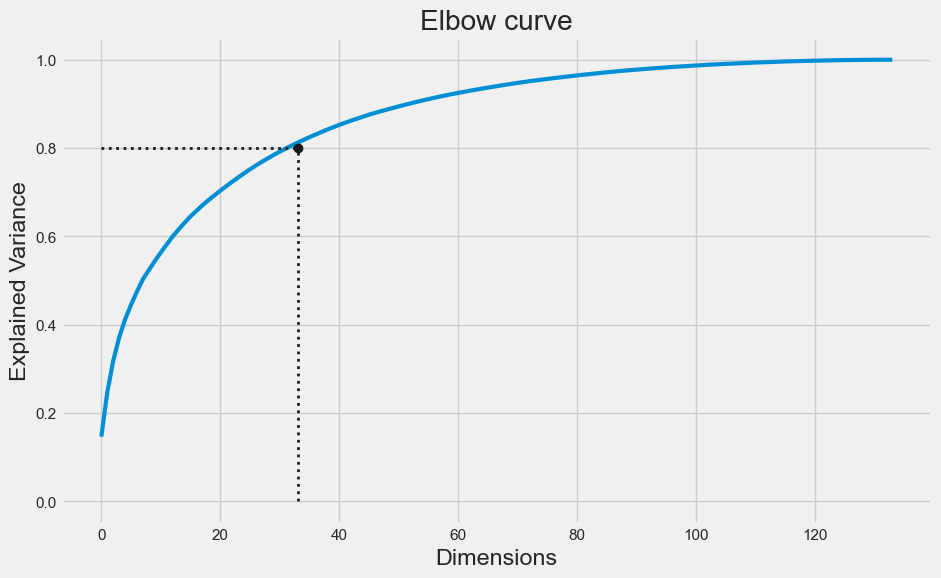

In [32]:
# graphically displaying the optimal components
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10, 6))
plt.plot(cumsum, linewidth=3)
plt.title("Elbow curve")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, threshold], "k:", linewidth=2)
plt.plot([0, d], [threshold, threshold], "k:", linewidth=2)
plt.plot(d, threshold, "ko")
plt.grid(True)
plt.show()

In [33]:
d

33

Using the elbow curve and a threshold of 80% explained variance, we find the optimal nubmer of dimensions to be 33. We will now create a seperate 

# 2.4.2 Reducing our dataframe using 33 components

In [36]:
# creating a dataframe with d number of components.
pca = PCA(n_components=d)
prinicpalComponents = pca.fit_transform(aisle_share_pivot.fillna(0))

PCA_components = pd.DataFrame(prinicpalComponents)
PCA_components

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.122382,0.028613,-0.047848,0.012767,-0.075257,-0.111795,-0.100805,0.088220,-0.064019,-0.002224,...,-0.003239,0.081738,0.031184,0.097978,0.022460,-0.029067,-0.007265,-0.000717,-0.007178,-0.001347
1,-0.034421,0.111616,-0.064131,-0.109469,0.073279,-0.029581,-0.049189,-0.058610,-0.010449,-0.018545,...,0.038622,0.007865,-0.005358,-0.002807,-0.000316,0.000883,-0.007179,-0.026203,0.027725,0.008560
2,0.063256,0.104112,0.000496,-0.014155,-0.047741,0.111107,-0.031844,0.012995,0.011880,0.004852,...,0.058403,-0.003982,0.000200,0.016042,-0.004763,-0.003448,0.002408,0.005747,-0.000999,-0.024818
3,-0.094301,0.052755,0.001040,-0.005059,-0.071588,-0.017785,-0.025076,-0.039013,0.009990,-0.013975,...,0.006977,0.006452,0.001074,0.008205,-0.015266,0.009494,0.002445,-0.074386,-0.015747,0.061965
4,0.089432,-0.031068,-0.022805,-0.011826,0.042321,0.111462,-0.015760,0.100986,0.025172,-0.036504,...,-0.005501,0.008714,0.001773,-0.006554,0.000294,0.001034,0.001569,0.006541,-0.000534,-0.005246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.001716,0.084855,-0.065398,-0.068637,0.114987,-0.028524,0.020653,0.023944,-0.027573,-0.016771,...,-0.003955,-0.026088,-0.005675,0.028499,-0.000724,-0.004775,-0.017529,-0.021081,0.030716,0.023755
206205,-0.089658,-0.046734,-0.048290,0.012790,-0.059580,-0.000549,-0.013953,-0.042906,0.143140,-0.060010,...,0.001441,0.044865,-0.009331,0.030399,0.032507,-0.033994,-0.001555,-0.012838,-0.012001,-0.013504
206206,-0.024827,-0.013520,-0.003968,-0.030920,0.032991,0.020686,0.037641,0.032888,-0.022782,-0.002567,...,0.007769,-0.003062,0.012410,-0.009361,0.005932,-0.003697,-0.006471,-0.005361,0.002737,-0.007244
206207,-0.009310,-0.003375,-0.045594,-0.012233,0.013766,0.055678,0.008122,0.029495,-0.010618,0.020785,...,-0.010636,-0.001513,-0.010103,0.012441,0.000653,-0.005569,0.005625,0.003310,0.007820,-0.008702


In [37]:
# sns.pairplot(PCA_components[range(d)])

## 2.5 Segmenting our users using K-Means

### 2.5.1 Find optimal number of clusters using elbow method

Using 3 different methods we evaluate the optimal number of clusters to use for our segmentation. 

In [38]:
# finding optimal number of clusters.
sse = {}
labels = {}
for k in range(2, 20):
    print(k)
    kmeans = KMeans(n_clusters=k).fit(PCA_components[range(d)])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


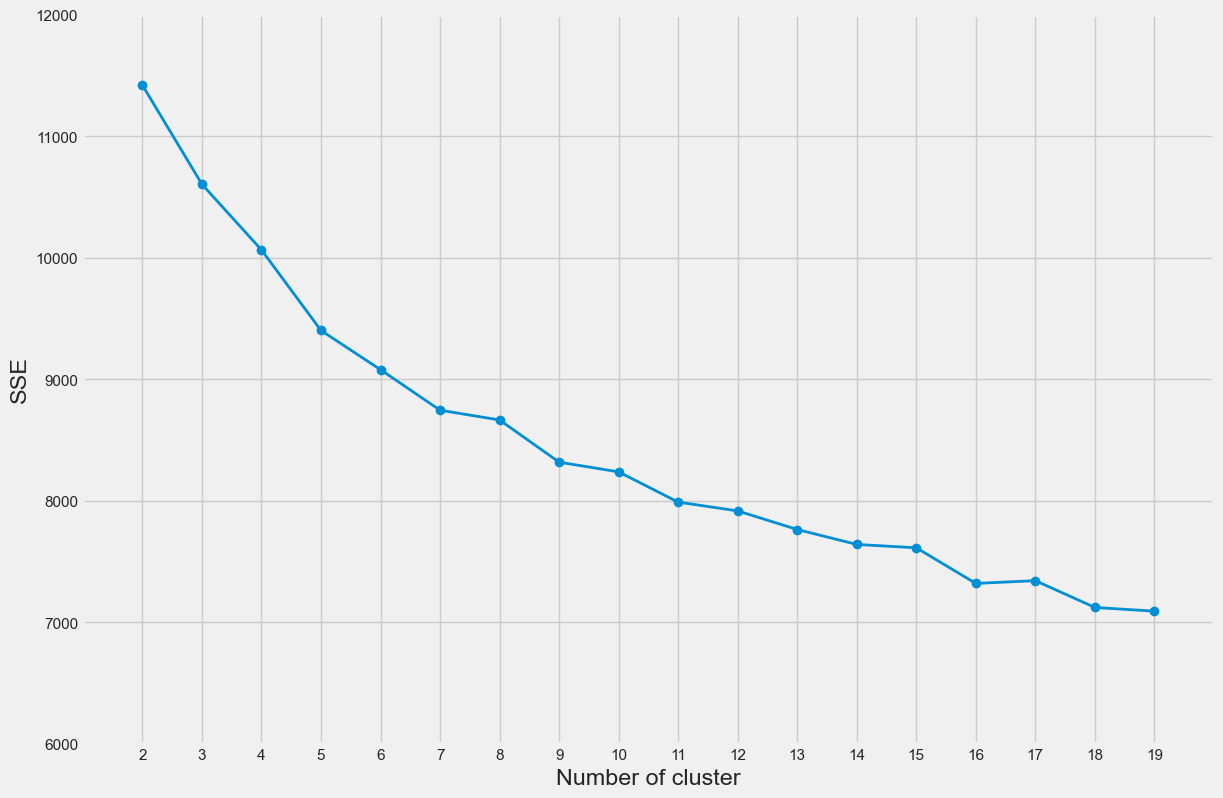

In [39]:
plt.figure(figsize=(13, 9))
plt.plot(list(sse.keys()), list(sse.values()), "-o", linewidth=2)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.ylim(6000, 12000)
plt.xlim(1, 20)
plt.xticks(range(2, 20))
plt.show()

Using the elbow method in this case is hard as there is no significant change in slope. 

Instead, we can find the place in which the slow down in pct %-change is the greatest.


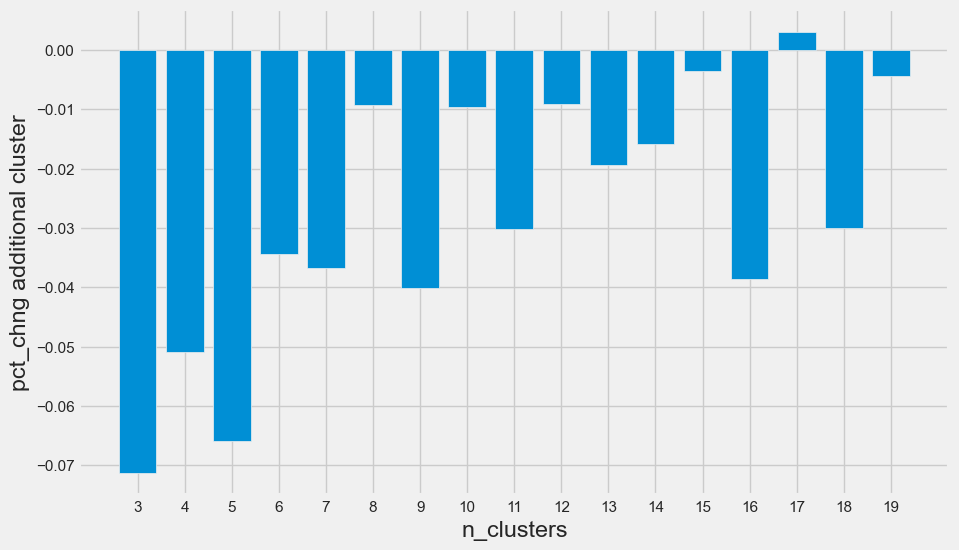

In [103]:
pct_change_clusters = pd.Series(sse.values()).pct_change()

plt.figure(figsize=(10,6))
plt.bar(sse.keys(), pct_change_clusters)
plt.xlabel("n_clusters")
plt.ylabel("pct_chng additional cluster")
plt.xticks(np.arange(3,20))
plt.show()

Looking at the bar chart graph we can see, that around 13 the pct changes kind of start balancing out. As such we decided to go for a cluster number of 13

In [41]:
# Setting k to 13
k = 13

In [42]:
# Filling the NaN with 0
aisle_share_pivot = aisle_share_pivot.fillna(0)

### 2.5.2 Alternative Clustering methods 

During our clustering we had a branch that explored DBSCAN/OPTICS as an alternative method for segmentation. However, due to the size of the dataset DBSCAN quickly ran out of memory as the algorithm in SciKit Learn is optimized towards performance. OPTICS however could solve this but the computational time never concluded. Therefore, K-Means was the optimal clustering algorithm for this size of data. 

## 2.6 Preparing our dataframe for collaborative filtering

We can now prepare our dataframe for export to use in our collaborative filtering in the next section. This is done over a few steps of merging dataframes with the goal of shaping a final df consisting of order_id, product_id, cluster & user_id.


In [44]:
# concatting cluster onto
cluster_df = pd.concat([PCA_components[range(d)], pd.Series(labels[k]).rename('cluster')], axis=1)

cluster_df = pd.concat([pd.Series(aisle_share_pivot.index), cluster_df],axis = 1)
cluster_df

,user_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,cluster
0,1,-0.122382,0.028613,-0.047848,0.012767,-0.075257,-0.111795,-0.100805,0.088220,-0.064019,...,0.081738,0.031184,0.097978,0.022460,-0.029067,-0.007265,-0.000717,-0.007178,-0.001347,8
1,2,-0.034421,0.111616,-0.064131,-0.109469,0.073279,-0.029581,-0.049189,-0.058610,-0.010449,...,0.007865,-0.005358,-0.002807,-0.000316,0.000883,-0.007179,-0.026203,0.027725,0.008560,1
2,3,0.063256,0.104112,0.000496,-0.014155,-0.047741,0.111107,-0.031844,0.012995,0.011880,...,-0.003982,0.000200,0.016042,-0.004763,-0.003448,0.002408,0.005747,-0.000999,-0.024818,3
3,4,-0.094301,0.052755,0.001040,-0.005059,-0.071588,-0.017785,-0.025076,-0.039013,0.009990,...,0.006452,0.001074,0.008205,-0.015266,0.009494,0.002445,-0.074386,-0.015747,0.061965,12
4,5,0.089432,-0.031068,-0.022805,-0.011826,0.042321,0.111462,-0.015760,0.100986,0.025172,...,0.008714,0.001773,-0.006554,0.000294,0.001034,0.001569,0.006541,-0.000534,-0.005246,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,0.001716,0.084855,-0.065398,-0.068637,0.114987,-0.028524,0.020653,0.023944,-0.027573,...,-0.026088,-0.005675,0.028499,-0.000724,-0.004775,-0.017529,-0.021081,0.030716,0.023755,1
206205,206206,-0.089658,-0.046734,-0.048290,0.012790,-0.059580,-0.000549,-0.013953,-0.042906,0.143140,...,0.044865,-0.009331,0.030399,0.032507,-0.033994,-0.001555,-0.012838,-0.012001,-0.013504,12
206206,206207,-0.024827,-0.013520,-0.003968,-0.030920,0.032991,0.020686,0.037641,0.032888,-0.022782,...,-0.003062,0.012410,-0.009361,0.005932,-0.003697,-0.006471,-0.005361,0.002737,-0.007244,4
206207,206208,-0.009310,-0.003375,-0.045594,-0.012233,0.013766,0.055678,0.008122,0.029495,-0.010618,...,-0.001513,-0.010103,0.012441,0.000653,-0.005569,0.005625,0.003310,0.007820,-0.008702,4


In [45]:
# Adding cluster number to our asile share per user dataframe
cluster_aisle_br = aisle_share_per_user.merge(cluster_df[['user_id', 'cluster']], on = 'user_id')
cluster_aisle_br

,user_id,aisle,aisle_share,cluster
0,1,candy chocolate,0.028571,8
1,1,cereal,0.057143,8
2,1,cream,0.042857,8
3,1,fresh fruits,0.071429,8
4,1,milk,0.014286,8
...,...,...,...,...
5919835,206209,soft drinks,0.080292,12
5919836,206209,soy lactosefree,0.072993,12
5919837,206209,spices seasonings,0.007299,12
5919838,206209,trash bags liners,0.007299,12


In [47]:
all_orders_cluster = all_orders.merge(cluster_df[['user_id', 'cluster']], on = 'user_id')
all_orders_cluster

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle,cluster
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,4
1,2,28985,2,1,202279,Michigan Organic Kale,83,4,produce,fresh vegetables,4
2,2,9327,3,0,202279,Garlic Powder,104,13,pantry,spices seasonings,4
3,2,45918,4,1,202279,Coconut Butter,19,13,pantry,oils vinegars,4
4,2,30035,5,0,202279,Natural Sweetener,17,13,pantry,baking ingredients,4
...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421063,14233,3,1,169679,Natural Artesian Water,115,7,beverages,water seltzer sparkling water,12
33819102,3421063,35548,4,1,169679,Twice Baked Potatoes,13,20,deli,prepared meals,12
33819103,3421070,35951,1,1,139822,Organic Unsweetened Almond Milk,91,16,dairy eggs,soy lactosefree,8
33819104,3421070,16953,2,1,139822,Creamy Peanut Butter,88,13,pantry,spreads,8


## 2.7 Exploring the clusters

In [48]:
# checking the number of users per cluster
user_per_cluster = all_orders_cluster.groupby("cluster").nunique()["user_id"]

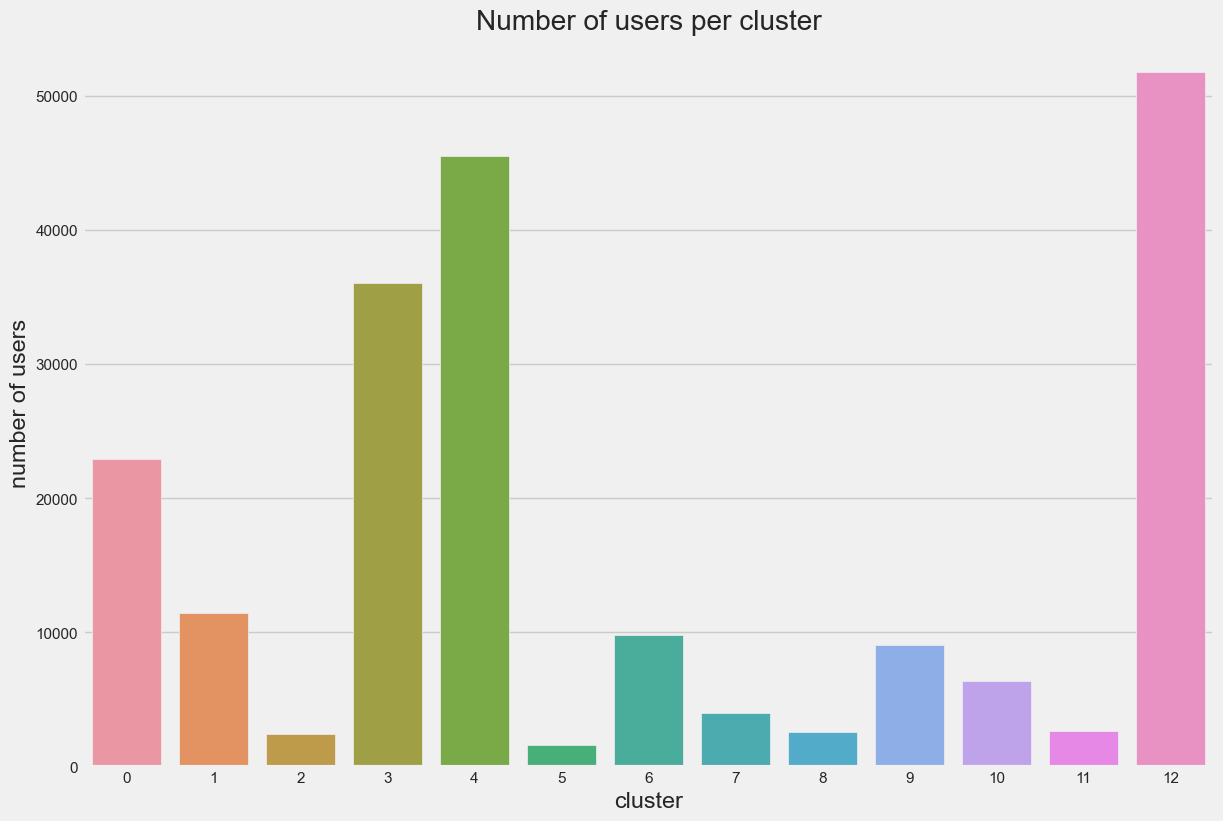

In [104]:
plt.figure(figsize=(13,9))
sns.barplot(x = user_per_cluster.index, y=user_per_cluster.values)
plt.title("Number of users per cluster")
plt.xlabel("cluster")
plt.ylabel("number of users")
plt.show()

Looking at the above graph we can see, that `cluster 0`, `cluster 8` and `cluster 12` have the most users, where as `cluster 2`, `cluster 3` and `cluster 10` have the least. Although users is an inidcator, let's see how it looks in terms of number of orders...

In [51]:
# Calculating the number of users per cluster
orders_per_cluster = all_orders_cluster.groupby("cluster")["order_id"].nunique()

As expected, the distribution of the total number of orders per cluster looks similar as the total number of users per clusters as more useres usually also means more orders. Let's explore the ratios...

When we look at the average number of orders per user we have a a bit a more even distribution. `cluster 2`, `cluster 4` and `cluster 12` users tend to order the most, where as `cluster 3`. `cluster 10`, and `cluster 11` users have the loweser average number of orders.

Next, let's check if there is a significant difference in the average number of products bought per order...

In [52]:
avg_num_prod_per_order_by_cluster = all_orders_cluster.groupby(["cluster", "order_id"]).count()["product_id"].groupby("cluster").mean()

Looking at the bar chart we can clearly see a difference between the different clusters. The average number of products per order for `cluster 2`, `cluster 3`, `cluster 6` and `cluster 10` is stark below the average of 8, where as for `cluster 0`, `cluster 1`, `cluster 4`. `cluster 5`. `cluster 8`, `cluster 11` and `cluster 12` it is clearly above.

Now let's see if we can find some patterns in the different clusters

In [53]:
orders_per_cluster.values

array([360451, 192906,  40572, 684076, 775623,  19264, 141388,  64464,
        34095, 138330, 100322,  37933, 756659], dtype=int64)

In [54]:
dep_vol_per_cluster = pd.DataFrame(all_orders_cluster.groupby(['cluster', "department"]).count())[
    ["order_id"]].unstack(level=0).divide(orders_per_cluster.values, axis=1)

In [55]:

# plt.figure(figsize=(13,9))
# sns.heatmap(data=dep_vol_per_cluster, cmap="Reds", linewidths=1, xticklabels=range(0,13))
# plt.xlabel("cluster")
# plt.show()

In [56]:
# Calculate the total number of orders per cluster
orders_per_cluster = all_orders_cluster.groupby("cluster")[
    "order_id"].nunique()

# Verify the number of clusters
num_clusters = len(orders_per_cluster)

# Check the length of the orders_per_cluster.values array
print("Length of orders_per_cluster.values array:",
      len(orders_per_cluster.values))

Length of orders_per_cluster.values array: 13


In [57]:
# Calculate the volume of orders per department per cluster
dep_vol_per_cluster = all_orders_cluster.groupby(
    ['cluster', 'department']).size().unstack(level=0)

In [58]:
# Check if the number of clusters matches the expected length
if num_clusters == len(dep_vol_per_cluster.columns):
    # Divide the volume of orders per department by the total orders per cluster
    dep_vol_per_cluster = dep_vol_per_cluster.divide(
        orders_per_cluster.values, axis=1)
else:
    print("Number of clusters does not match the length of dep_vol_per_cluster.columns")

In [59]:
dep_pct_per_cluster = pd.DataFrame(all_orders_cluster.groupby(
    ['cluster', 'department']).size().unstack(level=0))

Looking at the heatmap we can't really spot any patterns. Produce is popular in all the paterns, and also dairy eggs are. 

In [60]:
aisle_vol_per_cluster = all_orders_cluster.groupby(["cluster", "aisle"]).count(
)["order_id"].unstack(level=0).divide(orders_per_cluster.values, axis=1)

## 2.8 Exporting our clustered dataframe to pyarrow (for compression) for use in collaborative filtering algorithm.

In [61]:
dummy_df = all_orders_cluster[["order_id", "product_id", "cluster", "user_id"]]

In [62]:
table = pa.Table.from_pandas(dummy_df, preserve_index=False)

pq.write_table(table, f"dummy_k{k}.parquet")

In [63]:
zipObj = ZipFile(f'dummy_k{k}_parq.zip', 'w')
zipObj.write(f"dummy_k{k}.parquet")
zipObj.close()

## 3.0 Item2Vec 
Our recommender model is based on the Item2Vec specification, which is a direct transfer from the Word2Vec model first reported by Mikolov et al. (2013) at Google. Instead of using documents with Natural Language, we are using the individual orders of different customers as identified by the KMeans clustering. In this notebook, we are going to train 13 different Item2Vec models, one for each cluster that we have identified. We are going to restrict the data in that we only consider orders with at least 4 items in them, as this should give them recommender sufficient information, apart from the cluster the user belongs to, of course.

In [64]:
def import_data(data_dir: str) -> List[pd.DataFrame]:
    """
    Parameters:
    ----------------
    data_dir: str
      The path where the data is stored

    Returns:
    ----------------
    dataframes_ls: List[pd.DataFrame]
      A list of pandas dataframes
    """
    files = [file.split('.')[0] for file in listdir(
        data_dir) if file.split('.')[0] != ""]

    # Creating a string expression to evaluate the data
    eval_expr = ', '.join(
        f'pd.read_csv(\'{data_dir}/{file}.csv\')' for file in files)

    # Evaluating the expression and assigning it, which creates a list of dataframes
    dataframes_ls = eval(eval_expr)

    return dataframes_ls

In [65]:
products = pd.read_csv('products.csv')
cluster_data = pq.read_table('./dummy_k13.parquet').to_pandas()
cluster_data_named = pd.merge(cluster_data, products, on='product_id', how='inner')

In [66]:
cluster_data_named['product_id'] = cluster_data_named['product_id'].astype(str)
cluster_data_named['user_id'] = cluster_data_named['user_id'].astype(str)

In [67]:
def filter_data_by_cluster(data: pd.DataFrame, cluster_num: int):
    return data.loc[data['cluster'] == cluster_num, :]

In [68]:
clusters_separated = [filter_data_by_cluster(cluster_data_named, cluster_num) for cluster_num in range(
    0, len(cluster_data_named['cluster'].unique()))]

In [69]:
def split_users_in_cluster(cluster_data: pd.DataFrame, train_rate: float):
    unique_users = cluster_data['user_id'].unique()
    train_users = np.random.choice(unique_users, round(
        len(unique_users)*train_rate), False).tolist()
    test_users = [user for user in unique_users if user not in train_users]
    return train_users, test_users

In [70]:
train_test_tuples = [split_users_in_cluster(
    cluster, 0.75) for cluster in clusters_separated]

In [71]:
train_users = [users[0] for users in train_test_tuples]
test_users = [users[1] for users in train_test_tuples]

For computational ease, we are going to save the test users in a separate directory to save time when testing the model.

In [72]:
def save_test_users_in_cluster(test_users: list, cluster_num: int):

    with open(f'test_users_cluster{cluster_num}.pkl', 'wb') as file:
        pickle.dump(test_users, file)
    return f"Test users for cluster {cluster_num} saved."

In [73]:
[save_test_users_in_cluster(test_users[i], i+1) for i in range(len(test_users))]

['Test users for cluster 1 saved.',
 'Test users for cluster 2 saved.',
 'Test users for cluster 3 saved.',
 'Test users for cluster 4 saved.',
 'Test users for cluster 5 saved.',
 'Test users for cluster 6 saved.',
 'Test users for cluster 7 saved.',
 'Test users for cluster 8 saved.',
 'Test users for cluster 9 saved.',
 'Test users for cluster 10 saved.',
 'Test users for cluster 11 saved.',
 'Test users for cluster 12 saved.',
 'Test users for cluster 13 saved.']

In [74]:
def save_product_lookup(products: pd.DataFrame):
    product_lookup = dict(zip(products['product_id'].astype(
        str).to_list(), products['product_name'].to_list()))
    with open('product_lookup.pkl', 'wb') as file:
        pickle.dump(product_lookup, file)
        

save_product_lookup(products)

In [75]:
def subset_cluster(cluster: pd.DataFrame, train_users):
    return cluster[cluster['user_id'].isin(train_users)]

In [76]:
def get_orders_from_cluster(cluster_subset):
    return cluster_subset.groupby(['user_id', 'order_id'])['product_id'].apply(list).values

In [77]:
def generate_user_purchase_history_in_cluster(cluster: pd.DataFrame, train_users):
    cluster_subset = subset_cluster(cluster, train_users)
    purchase_history = get_orders_from_cluster(cluster_subset)
    filtered_purchase_history = [purchase for purchase in purchase_history if len(
        purchase) > 3]  # A number of purchases
    return purchase_history

In [78]:
purchase_history_in_cluster = [generate_user_purchase_history_in_cluster(
    clusters_separated[i], train_users[i]) for i in range(0, len(clusters_separated))]

In [79]:
def build_item2vec_model(purchases_data):

    model = Word2Vec(window=3, sg=1, hs=0, vector_size=100, negative=10,
                     alpha=0.03, min_alpha=0.0007, seed=28101997, workers=6)

    model.build_vocab(purchases_data, progress_per=200)

    model.train(purchases_data, total_examples=model.corpus_count,
                epochs=10, report_delay=1)

    return model

In [80]:
models = [build_item2vec_model(purchase_history)
          for purchase_history in purchase_history_in_cluster]

In [81]:
def save_cluster_model(model, id: int):
    model.save(f'model_cluster_{id}.model')
    return f"Model for cluster {id} successfully saved."

In [82]:
[save_cluster_model(models[i], i) for i in range(len(models))]

['Model for cluster 0 successfully saved.',
 'Model for cluster 1 successfully saved.',
 'Model for cluster 2 successfully saved.',
 'Model for cluster 3 successfully saved.',
 'Model for cluster 4 successfully saved.',
 'Model for cluster 5 successfully saved.',
 'Model for cluster 6 successfully saved.',
 'Model for cluster 7 successfully saved.',
 'Model for cluster 8 successfully saved.',
 'Model for cluster 9 successfully saved.',
 'Model for cluster 10 successfully saved.',
 'Model for cluster 11 successfully saved.',
 'Model for cluster 12 successfully saved.']

# 3.1 Recommendation Testing
Validating a recommender system is no trivial task. ECommerce companies usually trials them extensively using both online and offline sources. As this is not quite feasible in our case, we resolved to using a different approach: As discussed when training the Item2Vec models, we created on distinct model for each customer cluster. Next, we load the test users that we defined. We do make some assumptions when actually making the recommendations:

1. The (true) embedding of the basket can be approximated by a (softmax-weighted) average of the items contained in that basket.
2. As in training the Item2Vec models, we only consider orders that have at least 4 items in them as we believe that just having one item in the basket and predicting the remaining one is incredibly difficult.

We then proceeded to generate "artificial" test datasets by using a rolling convolution to extract "order windows" of the following shape (e.g. by using a filter of size 4x1):

([Item1, Item2, Item3, Item4, Item5]) : 
 
Convolution 1: [Item1, Item2, Item3, Item4]  
Convolution 2: [Item2, Item3, Item4, Item5]  

We then extract the first three basket elements as our "basket" (e.g. [Item1, Item2, Item3]), apply the recommender on these items and then compare with the last item  [Item4] in the convolution. 

We made an important observation when using the recommender here: Using a softmax-weighted basket (i.e. weighting the first element with $e^1$, the second with $e^2$ and then normalizing by the sum of $e^1$ to $e^3$) yields a superior result compared to using the simple mean. This is intuitive, as products that have been purchased at the beginning might not be so indicative of products further ahead in the cart.

Overall we find that the recommender performs reasonably well against a random benchmark. By simply using a random sample from the 60,000 products or so in Instacarts database, we would expected to be picking the right product with a chance of 1/59,999. Depending on the cluster used, we achieve accuracies as high as 9% (which might be a statistical fluke) and and as low as 0.9%, both of which are a significant improvement over a simple guess. We see that the overall error variance is quite pronounced between the clusters.


In [83]:
cluster_item_models = [Word2Vec.load(
    f"model_cluster_{id}.model") for id in range(0, 13)]

In [84]:
with open('product_lookup.pkl', 'rb') as file:
    product_lookup = pickle.load(file)

In [85]:
def load_test_users(id: int):
    with open(f"test_users_cluster{id}.pkl", "rb") as file:
        test_users = pickle.load(file)
    return test_users

In [86]:
test_users = [load_test_users(id) for id in range(1, 14)]

In [87]:
def import_data(data_dir: str) -> List[pd.DataFrame]:
    """
    Parameters:
    ----------------
    data_dir: str
      The path where the data is stored

    Returns:
    ----------------
    dataframes_ls: List[pd.DataFrame]
      A list of pandas dataframes
    """
    files = [file.split('.')[0] for file in listdir(
        data_dir) if file.split('.')[0] != ""]

    # Creating a string expression to evaluate the data
    eval_expr = ', '.join(
        f'pd.read_csv(\'{data_dir}/{file}.csv\')' for file in files)

    # Evaluating the expression and assigning it, which creates a list of dataframes
    dataframes_ls = eval(eval_expr)

    return dataframes_ls

In [88]:
products = pd.read_csv('products.csv')
cluster_data = pq.read_table('./dummy_k13.parquet').to_pandas()
cluster_data_named = pd.merge(cluster_data, products, on='product_id', how='inner')

In [89]:
cluster_data_named['product_id'] = cluster_data_named['product_id'].astype(str)
cluster_data_named['user_id'] = cluster_data_named['user_id'].astype(str)

In [90]:
def filter_data_by_cluster(data: pd.DataFrame, cluster_num: int):
    return data.loc[data['cluster'] == cluster_num, :]

In [91]:
clusters_separated = [filter_data_by_cluster(cluster_data_named, cluster_num) for cluster_num in range(
    0, len(cluster_data_named['cluster'].unique()))]

In [92]:
def subset_cluster(cluster: pd.DataFrame, users):
    return cluster[cluster['user_id'].isin(users)]

In [93]:
def get_orders_from_cluster(cluster_subset):
    return cluster_subset.groupby(['user_id', 'order_id'])['product_id'].apply(list).values

In [94]:
def generate_user_purchase_history_in_cluster(cluster: pd.DataFrame, users):
    cluster_subset = subset_cluster(cluster, users)
    purchase_history = get_orders_from_cluster(cluster_subset)
    filtered_purchase_history = [purchase for purchase in purchase_history if len(
        purchase) > 3]  # A number of purchases
    return purchase_history

In [95]:
purchase_history_validation = [generate_user_purchase_history_in_cluster(
    clusters_separated[i], test_users[i]) for i in range(0, len(clusters_separated))]

As explained above, the product recommender retrieves the k most similar items for the averaged item vectors in the basket and checks whether one of the recommended products is indeed the next item. 

In [96]:
def recommend_product(cluster_model, product_lookup, product_ids):

    def filter_matches(cluster_model, product_ids):
        return [product_id for product_id in product_ids if cluster_model.wv.__contains__(product_id)]

    filtered_matches = filter_matches(cluster_model, product_ids)

    if len(filtered_matches) == 0:
        return 'UNKNOWN'  # Returning an "UNKNOWN" token for an empty basket
    else:
        def average_item_vectors(cluster_model, product_ids):
            embeddings = [cluster_model.wv[product_id]
                          for product_id in product_ids]

            def softmax_weights(embeddings):
                raw_weights = [np.exp(i) for i in range(1, len(embeddings)+1)]
                softmax_weights = np.array(
                    [raw_weight/sum(raw_weights) for raw_weight in raw_weights])
                return softmax_weights
            sm_weights = softmax_weights(embeddings)
            return np.average(embeddings, axis=0, weights=sm_weights)

        basket_vector = average_item_vectors(cluster_model, filtered_matches)

        def retrieve_most_similar_products(cluster_model, product_lookup, basket_vector):
            similar_products = cluster_model.wv.similar_by_vector(basket_vector, topn=15)[
                1:]
            recommendations = [similar[0] for similar in similar_products]

            return recommendations

        recommendations = retrieve_most_similar_products(
            cluster_model, product_lookup, basket_vector)

        return recommendations

In [97]:
def convolve_prediction_filter(history: np.array, filter_shape: np.array):
    history_expanded = np.expand_dims(history, axis=1)
    masks = sliding_window_view(history_expanded, filter_shape)
    return masks

In [98]:
def validate_recommendations(cluster_model, mask: np.array, product_lookup: dict):
    basket = mask.flatten()[:-1]
    target_item = mask.flatten()[-1]
    recommendations = recommend_product(cluster_model, product_lookup, basket)

    if target_item in set(recommendations):
        return 1
    else:
        return 0

In [99]:
def score_cluster_model(cluster_model, product_lookup, cluster_history):
    validation_history = [np.array(history)
                          for history in cluster_history if len(history) > 3]
    masks = [convolve_prediction_filter(
        history, (4, 1)) for history in validation_history]
    chained_masks = list(chain.from_iterable(masks))

    order_score = sum([validate_recommendations(
        cluster_model, mask, product_lookup) for mask in masks])/len(masks)

    return order_score

In [102]:
results = [score_cluster_model(cluster_item_models[i], product_lookup,purchase_history_validation[i]) for i in range(len(cluster_item_models))]
[(f"Cluster {i+1}", round(results[i], 4)) for i in range(len(results))]

[('Cluster 1', 0.0184),
 ('Cluster 2', 0.0434),
 ('Cluster 3', 0.0204),
 ('Cluster 4', 0.0434),
 ('Cluster 5', 0.0383),
 ('Cluster 6', 0.0524),
 ('Cluster 7', 0.0263),
 ('Cluster 8', 0.0123),
 ('Cluster 9', 0.0282),
 ('Cluster 10', 0.0236),
 ('Cluster 11', 0.0049),
 ('Cluster 12', 0.0049),
 ('Cluster 13', 0.0297)]